In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc, mean_squared_error, mean_absolute_error
import numpy as np
import torch
import torch.nn as nn


# QUESTION 1

In [2]:
# Loading our dataset into pandas object 
log_reg_dataset = pd.read_csv('logistic-regression-dataset-Social-Network_Ads.csv')

# Before We Train our dataset on a logistic-regression model. we perform Decriptive Analysis on the data to get insight about our data First

####  Viewing The Datast to have a generic overview of the dataset

In [3]:
log_reg_dataset

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


There is only one Target variable Purchased with two labels 0 indicating just clicks i.e the customer juct
clickd without buying, and 1 for Purchased 

The dimension of our dataset is 400 x 4

The kappa index of the dataset is 100>5 which indicate that when we fit a model on the dataset it is likely to train well and give better generalization

#### Summary of the dataset

In [4]:
summary_info = log_reg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


#### Cheking for missing data

In [5]:
missing_data_count = log_reg_dataset.isnull().sum()

# Print the number of missing values in each column
print("Number of missing values in each column:")
print(missing_data_count)

Number of missing values in each column:
User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64


From the above it is clear that our dataset contains no missing data

### Checking the number of clicks againt Purchased

Click Counts:
Purchased
0    257
1    143
Name: count, dtype: int64


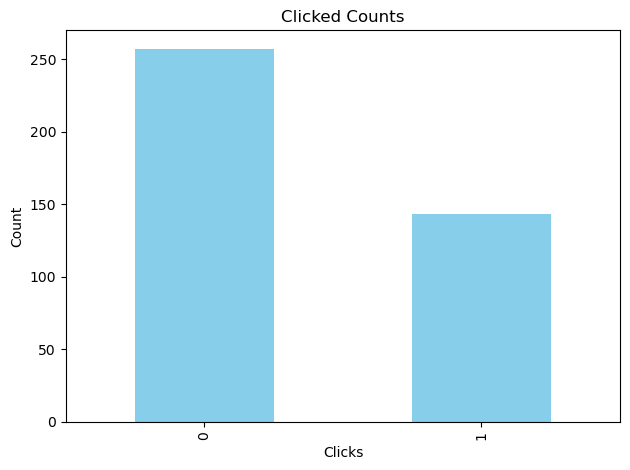

In [6]:
click_counts = log_reg_dataset['Purchased'].value_counts()

print("Click Counts:")
print(click_counts)

click_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Clicks')
plt.ylabel('Count')
plt.title('Clicked Counts')
plt.tight_layout()
plt.show()

Pron the above plot, we identify that out of the 400 people in the dataset, the number of Purchsed is 143 and just clicked is 247  

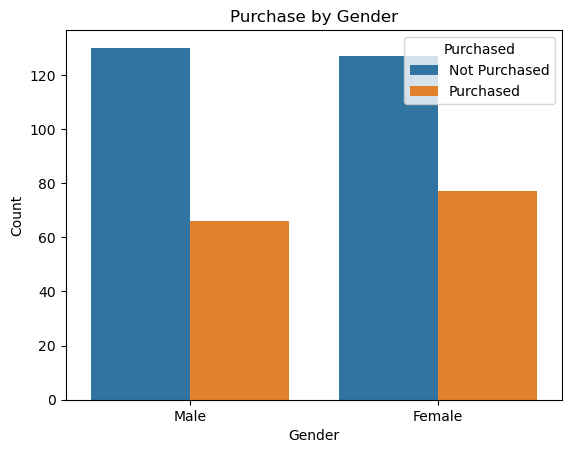

In [7]:
sns.countplot(x='Gender', hue='Purchased', data=log_reg_dataset)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Purchase by Gender')
plt.legend(title='Purchased', labels=['Not Purchased', 'Purchased'])

plt.show()


From the above barplot it obvious that purchased rate of Males and Females are almost the same and similar to just clicks

 ## Descriptive statistics for the 'age' column

In [8]:
# Descriptive statistics for the 'age' column
age_stats = log_reg_dataset['Age'].describe()

print("Descriptive Statistics for Age:")
print(age_stats)


Descriptive Statistics for Age:
count    400.000000
mean      37.655000
std       10.482877
min       18.000000
25%       29.750000
50%       37.000000
75%       46.000000
max       60.000000
Name: Age, dtype: float64


#### From the above statistics, we realize that the youngest customer in our dataset is 18 years old and the oldest is 60. The mean age is also 37 years

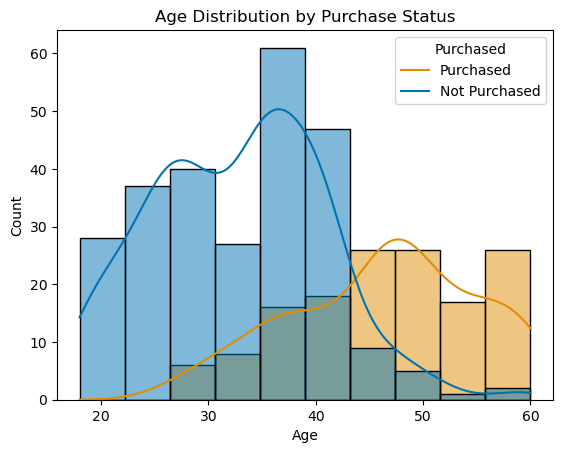

In [9]:
sns.histplot(data=log_reg_dataset, x='Age', hue='Purchased', kde=True, palette='colorblind')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Purchase Status')


plt.legend(title='Purchased', labels=['Purchased','Not Purchased'])


plt.show()

The above graph is the age distribution against Purchased. Show that the older customers purchse more than the younger customers

So most younger sustomers click without purchasing. And from The graph to you can tell that the  dataset contains more young customers than older ones

## Descriptive statistics for the 'Salay' column

In [10]:
# Descriptive statistics for the 'salary' column
salary = log_reg_dataset['EstimatedSalary'].describe()

print("Descriptive Statistics for EstimatedSalary:")
print(salary)


Descriptive Statistics for EstimatedSalary:
count       400.000000
mean      69742.500000
std       34096.960282
min       15000.000000
25%       43000.000000
50%       70000.000000
75%       88000.000000
max      150000.000000
Name: EstimatedSalary, dtype: float64


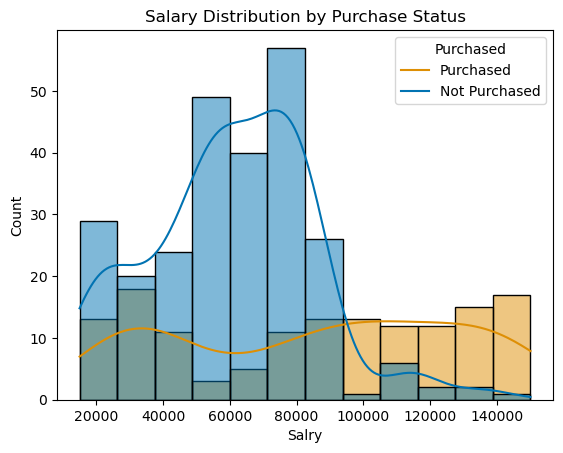

In [11]:
sns.histplot(data=log_reg_dataset, x='EstimatedSalary', hue='Purchased', kde=True, palette='colorblind')

plt.xlabel('Salry')
plt.ylabel('Count')
plt.title('Salary Distribution by Purchase Status')


plt.legend(title='Purchased', labels=['Purchased','Not Purchased'])


plt.show()

The distribution of purchased between the salry 20000 and 600000 looks normally distributed and similaely to to the salry range 60000 to 140000 

It turns out that people with low salry mostly just clicked more than the rich customers

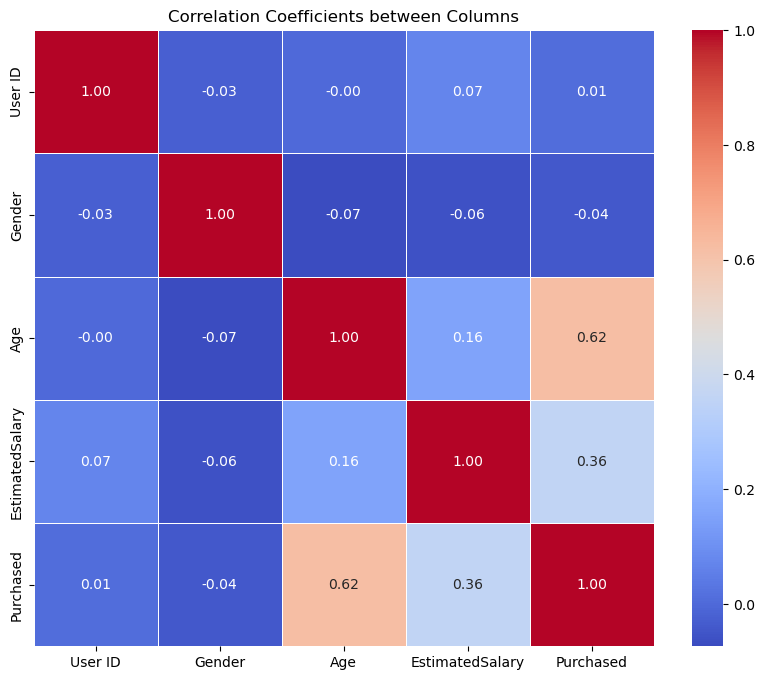

In [12]:
df=log_reg_dataset
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Coefficients between Columns')



plt.show()

In [13]:
purchased_correlation = correlation_matrix['Purchased'].sort_values(ascending=False)

print(purchased_correlation)

Purchased          1.000000
Age                0.622454
EstimatedSalary    0.362083
User ID            0.007120
Gender            -0.042469
Name: Purchased, dtype: float64


# TRANING LOGISTICREG ON DATA

In [14]:
X = log_reg_dataset.drop(columns=['User ID', 'Purchased'])
y = log_reg_dataset['Purchased']

# Spliting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling for best performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the logistic regression model
model = LogisticRegression()

# Training the model on the train data
model.fit(X_train_scaled, y_train)




LogisticRegression()

## Using Different optimization algorithm To train my model 

In [15]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
results = {}

for s in solvers:
    # Initialize the logistic regression model with the selected solver
    model = LogisticRegression(solver=s)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    results[s] = accuracy

# Print the results
print("Accuracy Scores:")
for solver, accuracy in results.items():
    print(f"{solver}: {accuracy}")

Accuracy Scores:
liblinear: 0.8875
newton-cg: 0.8875
lbfgs: 0.8875
sag: 0.8875
saga: 0.8875


 #### The result above shows that the accuracy levels after optimizing the model with different optimization algorithms are all the same

## Test and validate your model.

Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        52
           1       0.91      0.75      0.82        28

    accuracy                           0.89        80
   macro avg       0.90      0.86      0.87        80
weighted avg       0.89      0.89      0.88        80


Confusion Matrix:
[[50  2]
 [ 7 21]]


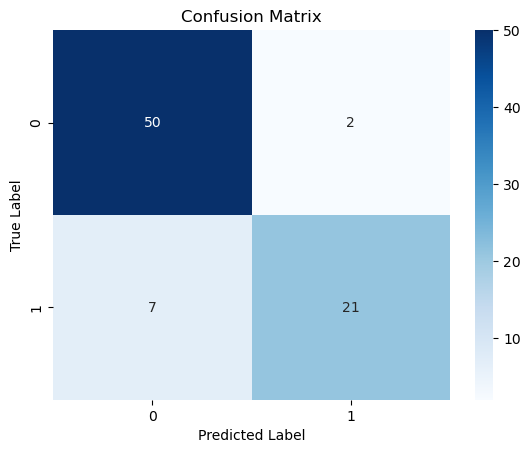

In [16]:
# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The above diagram is the confusion matrix of the predicted lable 

In [17]:
#Performing cross validation on the dataset with the model to find the average perfomance(accuracy) of the model

x_s = scaler.fit_transform(X)
#y_s = scaler.fit_transform(y)
cv_scores = cross_val_score(model,x_s, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.675 0.675 0.95  0.95  1.    0.9   0.8   0.775 0.8   0.7  ]
Mean CV score: 0.8225


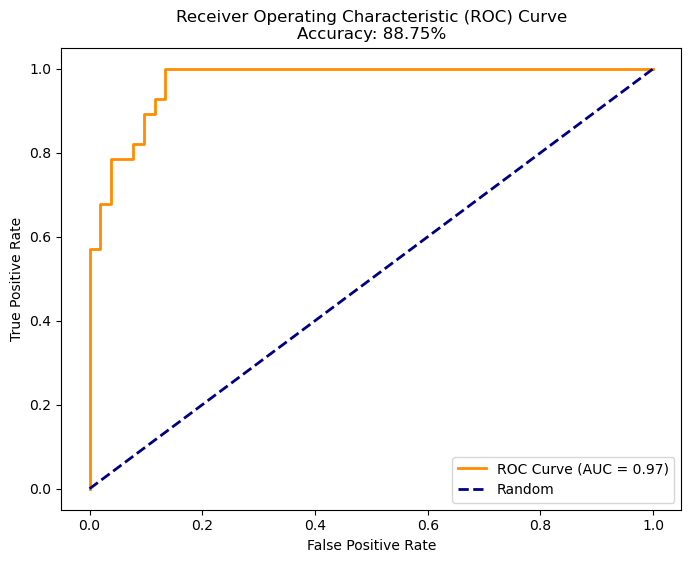

In [18]:
# Plot ROC Curve
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.legend(loc="lower right")
plt.show()


# QUESTION 2

### 2a) Checking if the dataset is clean. If not, I do pre-processing.

In [19]:
data = pd.read_csv('SolarPrediction.csv')

In [20]:
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [21]:
missing_data = data.isnull().sum()

# Print the number of missing values in each column
print("Number of missing values in each column:")
print(missing_data)

Number of missing values in each column:
UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64


### The above analysis shows that there is no missing data in our dataset

In [22]:
#Renaming the Data column to 'Date'
data.rename(columns={'Data': 'Date'}, inplace=True)

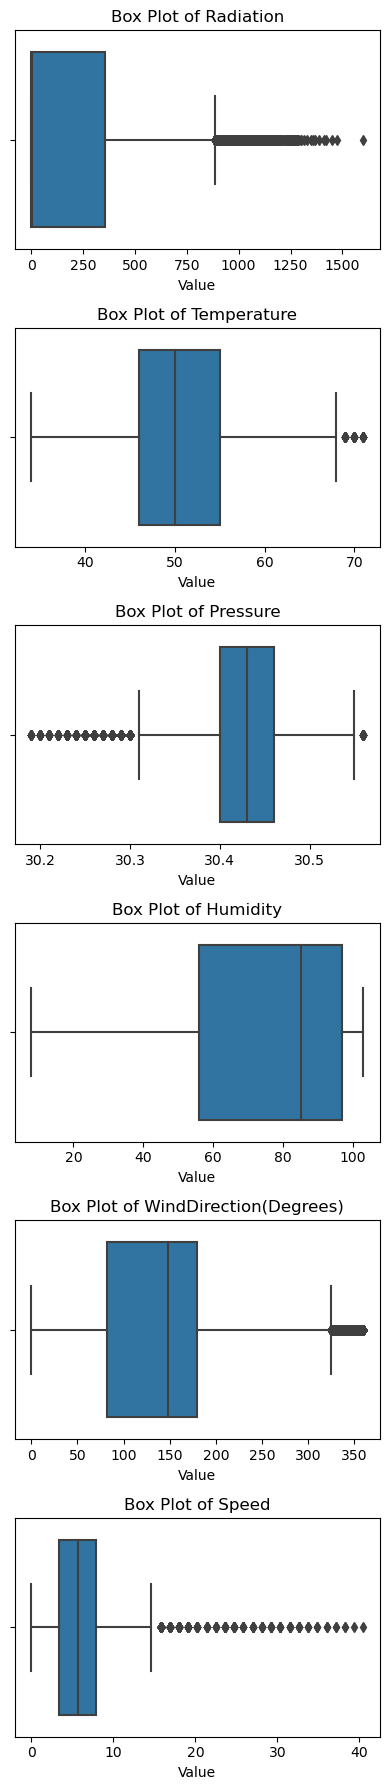

In [23]:
# Select the numerical columns
numerical_columns = ["Radiation", "Temperature","Pressure", "Humidity" , "WindDirection(Degrees)", "Speed"]

# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(4, 3 * len(numerical_columns)))

# Plot each numerical column on a separate subplot using Seaborn
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=data[column], ax=axes[i], orient='h')
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('')  # Remove y-axis label for better clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


From the boxplots above, they show that all the numerical variables are having outliers except humidity

We will solve this problem by removing rows with ouliers

### REMOVING OUTLIERS

In [24]:
 # Define the list of numerical columns
numerical_columns = ["Temperature","Pressure" , "WindDirection(Degrees)", "Speed"]

# Iterate over each numerical column
for col in numerical_columns:
    # Calculate the first quartile (Q1)
    Q1 = data[col].quantile(0.25)
    
    # Calculate the third quartile (Q3)
    Q3 = data[col].quantile(0.75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers from the dataset
    cleaned_data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]


In [25]:
cleaned_data

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


#### Future Engineering


In [26]:
cleaned_data.loc[:, "Daylight_Duration"] =( pd.to_datetime(cleaned_data['TimeSunSet'], format="%H:%M:%S") - pd.to_datetime(cleaned_data["TimeSunRise"], format="%H:%M:%S")).dt.total_seconds() / 3600


C:\Users\Admin\AppData\Local\Temp\ipykernel_15732\1557871362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.loc[:, "Daylight_Duration"] =( pd.to_datetime(cleaned_data['TimeSunSet'], format="%H:%M:%S") - pd.to_datetime(cleaned_data["TimeSunRise"], format="%H:%M:%S")).dt.total_seconds() / 3600


In [27]:
cleaned_data

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Daylight_Duration
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,12.000000
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,12.000000
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,12.000000
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,12.000000
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,11.016667
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,11.016667
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,11.016667
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,11.016667


In [28]:
cleaned_data.drop(columns=['UNIXTime', 'Date', 'Time', 'TimeSunRise', 'TimeSunSet'], inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15732\3720913507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.drop(columns=['UNIXTime', 'Date', 'Time', 'TimeSunRise', 'TimeSunSet'], inplace=True)


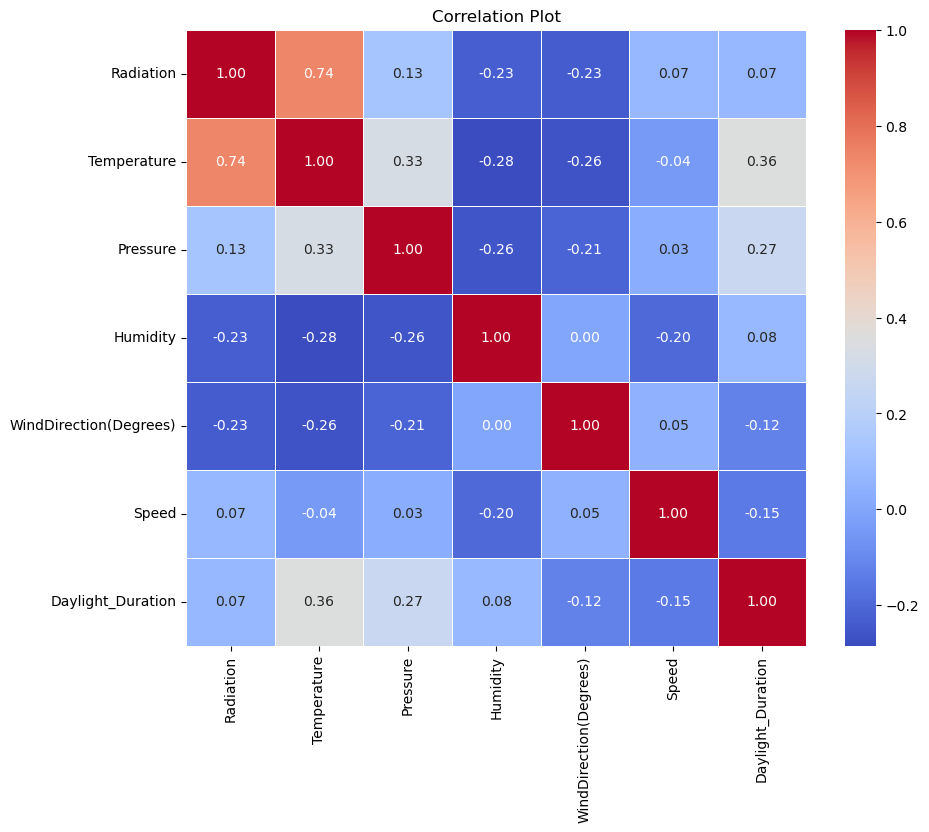

In [29]:
correlation_matrix = cleaned_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')
plt.show()


In [30]:
Radition_correlation = correlation_matrix['Radiation'].sort_values(ascending=False)

print(Radition_correlation)

Radiation                 1.000000
Temperature               0.735103
Pressure                  0.128807
Speed                     0.074467
Daylight_Duration         0.073794
Humidity                 -0.229990
WindDirection(Degrees)   -0.234554
Name: Radiation, dtype: float64


In [31]:
scaler = MinMaxScaler()
cleaned_data = scaler.fit_transform(cleaned_data)

### 2b) Using pyTorch to design a neural network with two hidden layers to be able to predict the radiation level with good accuracy

In [32]:
features = cleaned_data[:, 1:]  # Features contain independent variables
target = cleaned_data[:, 0]     # Target contains dependent variable



# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure y_train_tensor has shape (n_samples, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # Ensure y_test_tensor has shape (n_samples, 1)

# Step 2: Defining feedforward neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Step 3: Training the feedforward neural network
input_size = X_train.shape[1]  # Number of features
hidden_size1 = 40
hidden_size2 = 20
model_FNN = FeedForwardNN(input_size, hidden_size1, hidden_size2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_FNN.parameters(), lr=0.001)

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model_FNN(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0201
Epoch [200/1000], Loss: 0.0139
Epoch [300/1000], Loss: 0.0127
Epoch [400/1000], Loss: 0.0121
Epoch [500/1000], Loss: 0.0117
Epoch [600/1000], Loss: 0.0115
Epoch [700/1000], Loss: 0.0113
Epoch [800/1000], Loss: 0.0111
Epoch [900/1000], Loss: 0.0110
Epoch [1000/1000], Loss: 0.0109


## Test and validate your model.


In [33]:
# Step 4: Evaluate the model
with torch.no_grad():
    y_pred = model_FNN(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    # Calculate residuals
    residuals = y_pred - y_test_tensor

    # Calculate Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(residuals))
    print(f'Mean Absolute Error (MAE): {mae.item():.4f}')

    # Calculate Root Mean Squared Error (RMSE)
    mse = torch.mean(residuals**2)
    rmse = torch.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse.item():.4f}')
# Calculate total sum of squares (TSS)
TSS = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)

# Calculate residual sum of squares (RSS)
RSS = torch.sum(residuals**2)

# Calculate R-squared score
R_squared = 1 - (RSS / TSS)
print(f'R-squared score: {R_squared.item():.4f}')

# Calculate mean squared error (MSE)
MSE = torch.mean(residuals**2)
print(f'Mean Squared Error (MSE): {MSE.item():.4f}')


Test Loss: 0.0111
Mean Absolute Error (MAE): 0.0653
Root Mean Squared Error (RMSE): 0.1055
R-squared score: 0.7073
Mean Squared Error (MSE): 0.0111


(6442, 1) (6442, 1)


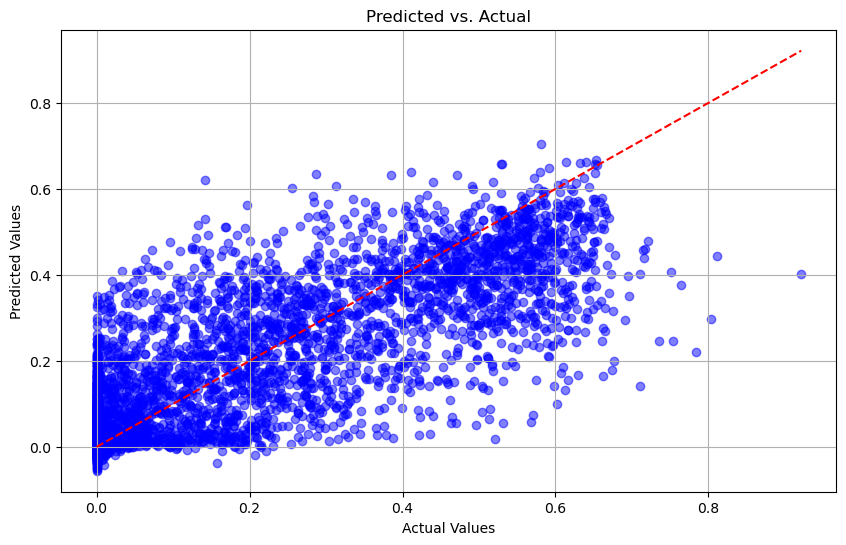

In [34]:

y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()
print(y_pred_np.shape,y_test_np.shape)
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np, color='blue', alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color='red', linestyle='--')
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [35]:
thresholds = [0.5, 1.5, 2.5]  

y_pred_classes = np.digitize(y_pred_np, thresholds)
y_test_classes = np.digitize(y_test_np, thresholds)
# Calculate confusion matrix
conf_matrix_ = confusion_matrix(y_test_classes, y_pred_classes)
# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_)

Confusion Matrix:
[[5778   79]
 [ 428  157]]


## Comparison of Model Performance

**The statistics of the model from the article are as follows:**
- Root Mean Squared Error (RMSE): 0.8361
- R-squared (R^2) Score: 0.9838

**The statistics of my model are as follows:**
- Root Mean Squared Error (RMSE): 0.1038
- R-squared (R^2) Score: 0.7167
- Mean Absolute Error (MAE): 0.0630
- Mean Squared Error (MSE): 0.0108

## Comments
The article's top-performing ANN model achieved an impressive R-squared (R^2) score of 0.9838. In contrast, my model achieved an R-squared (R^2) score of 0.7167 on the test data.In terms of RMSE, my model outperforms the model from the article, indicating enhanced accuracy in predicting the variance of the target variable. However, when considering the R-squared score, the model from the article demonstrates significantly better performance than mine, indicating its ability to explain a larger proportion of the variance in the target variable.



In summary, although my model's R-squared (R^2) score is lower than the model in the article, its RMSE, MAE, and MSE closely match the reported results. This indicates that while my model may not perform as well overall, it still demonstrates strong performance on other evaluation metrics. To enhance its performance and achieve results closer to those reported in the article, adjustments to the model architecture or hyperparameters may be needed.
